In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(".", "transformers")))
from preprocessing_part_2 import * 
from column_selectors import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score,davies_bouldin_score
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.cluster import DBSCAN

In [2]:
new_train_df = pd.read_csv('dataframes/train_geo_clustered.csv')
new_val_df = pd.read_csv('dataframes/val_geo_clustered.csv')

*This dataframe is already split into train,val,test in Feature Engineering file and saved to csv*

<span style="color:orange;">Dla grupy walidacyjnej: po wywołaniu skyptu Feature Engineering powinniście mieć nową ramkę test_df do używania zamiast new_val_df</span>

In [3]:
# we have a train df with a new column from first clusterization
new_train_df.head(2)

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category,geo_cluster
0,Lead Handyman Services,25.324796,55.417346,-0.135231,1.061147,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,1,1,Service,0
1,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,-0.136699,1.061147,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Attorney,0


# Feature engineering part 2

We still have some columns to delete:
* name - is unique for every company
* latitude and longitude - these features were used for first clustering, now we have geo_cluster so we don't need them anymore
* Friday,...Sunday - We already have binary columns like monday_morning/monday_evening etc

Column that we have to encode: main category

In [3]:
pipes1 = Pipeline([('remove_more_cols',MoreColumnsRemover()), # removing irrelevant columns mentioned above
                   ('encoder', CategoryEncoder()),    # label encoding 'main'category' column
                   ('bool_encode', BooleanToNumericEncoder())]) #bools to 0-1
train_df = pipes1.fit_transform(new_train_df)

<Axes: >

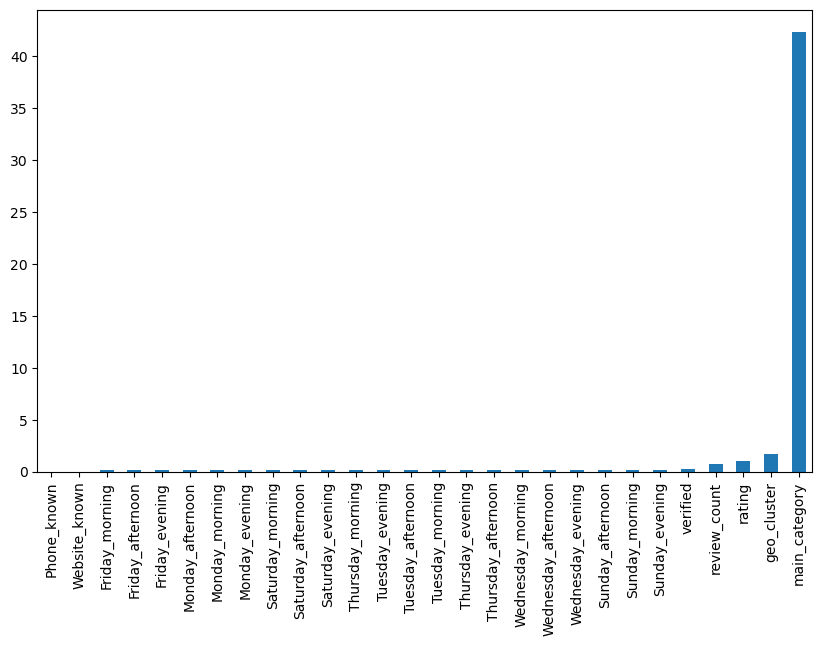

In [4]:
#check column's variances before standarization
variances = train_df.var()
sorted_variances = variances.sort_values()
plt.figure(figsize=(10, 6))
sorted_variances.plot(kind='bar')

<Axes: >

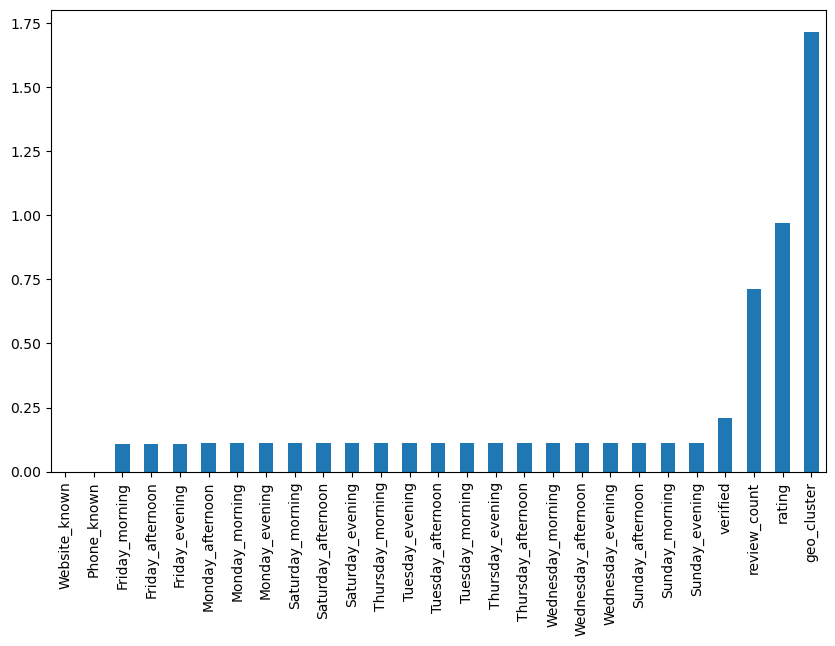

In [5]:
# as validation group suggested - another plot but without dominant main_category:
variances = train_df.drop(columns=['main_category']).var()
sorted_variances = variances.sort_values()
plt.figure(figsize=(10, 6))
sorted_variances.plot(kind='bar')

In [6]:
print("Wariancje cech:\n", sorted_variances)

Wariancje cech:
 Website_known          0.000000
Phone_known            0.000000
Friday_morning         0.106481
Friday_afternoon       0.106481
Friday_evening         0.106481
Monday_afternoon       0.109538
Monday_morning         0.109538
Monday_evening         0.109538
Saturday_morning       0.109638
Saturday_afternoon     0.109638
Saturday_evening       0.109638
Thursday_morning       0.109688
Tuesday_evening        0.109688
Tuesday_afternoon      0.109688
Tuesday_morning        0.109688
Thursday_evening       0.109688
Thursday_afternoon     0.109688
Wednesday_morning      0.109787
Wednesday_afternoon    0.109787
Wednesday_evening      0.109787
Sunday_afternoon       0.111129
Sunday_morning         0.111129
Sunday_evening         0.111129
verified               0.208843
review_count           0.712063
rating                 0.970009
geo_cluster            1.718311
dtype: float64


Variance analysis will help us with selecting the best dataframe to use in clustering.

We will create 3 selectors to select different subsets of columns in column_selector.py file.

## Feature selection

In [7]:
selector1 = Pipeline([('three_biggest_var', FirstColumnSelector())]) # in this selector we select 4 features with biggest variance
selector2 = Pipeline([('Variance_greater_than_015' ,SecondColumnSelector())]) # we select features with variance > threshold 0.15
selector3 = Pipeline([('Variance_greater_than_0', ThirdColumnSelector())]) # we select features with variance>0

train_df1 = selector1.fit_transform(train_df)
train_df2 = selector2.fit_transform(train_df)
train_df3 = selector3.fit_transform(train_df)

## Feature standardization

In [8]:
standardizer = Pipeline([('standardizer', SecondStandardizer())])
train_df_original = train_df # to preserve unscaled values
train_df1 = standardizer.fit_transform(train_df1)
train_df2 = standardizer.fit_transform(train_df2)
train_df3 = standardizer.fit_transform(train_df3)

In [9]:
train_df1 #check standardized df

,geo_cluster,rating,review_count,main_category
0,-0.528633,1.012531,-0.116107,0.568061
1,-0.528633,1.012531,-0.117847,-2.349915
2,0.234260,-0.349834,0.120765,0.721638
3,-0.528633,0.255662,-0.085535,0.260905
4,-0.528633,0.861157,-0.082304,0.568061
...,...,...,...,...
15034,-0.528633,-1.863572,-0.045021,-0.814138
15035,2.522939,-0.198460,-0.065651,-1.582027
15036,2.522939,0.104288,-0.111385,0.568061
15037,0.234260,-1.712198,-0.107408,-2.042760


### *At this point we have 3 dataframes with selected different columns*

# PCA

In [10]:
#let's see if we can achieve little information loss with only 3 components
def print_explained_variance(df):
    pca = PCA(n_components=3)
    pca.fit(df)
    print(pca.explained_variance_ratio_)

In [11]:
print_explained_variance(train_df3)

[0.79093257 0.04791902 0.0401213 ]


Explained variance measures the proportion of variance in the data that is explained by each principal component. We can see that the first component explains 79% of variance

In [12]:
def print_optimal_components(df, trehslod): # check how many components do we need to reach a given treshold
    pca = PCA(trehslod)
    pca.fit(df)
    print(pca.n_components_)

In [13]:
print_optimal_components(train_df3, .85) # no point in checking for df1 and df2 as they have just a few columns

3


We need 3 components to keep 85% of info

In order to have 85% of the variance explained we need 3 components. Our dataframe has 50 so that is a great reduction

# Model evaluation metrics

First let's look at some evaluation metrics that we will use for chooseing the best model.
1. **Silhouuette Score** - how each point is similar to other points in it's cluster (form -1 to 1)
2. **Davies-Bouldin Index** - how a given cluster is similar to the next one (the higher the score the worse)
3. **minimal distance between clusters** - minimal distance between two points that are in different clusters (cluster separation)
4. **mean distance to the cluster center** - average distance between points in clusters and cluster center
5. **mean inclust distance** - How close are points to each other in one cluster?

Also let's create some custom metrics like small distances among cluster, good cluster separation and good representation by center

In [14]:
#functions from Lab9 for minimal distance between clusters and distance to center and minimal inclust distance
def min_interclust_dist(df, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(df[cluster_i_idx], df[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [15]:
#function to create a summary of scores for a given model and dataframe
def create_report(model, data): #model must be fit!
    labels = model.labels_

    silhouette = silhouette_score(data,labels)
    davies = davies_bouldin_score(data,labels)

    X = data.values

    min_interclust = min_interclust_dist(X,labels)
    mean_center = mean_dist_to_center(X,labels)
    mean_inclust = mean_inclust_dist(X,labels)

    result = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Min interclust distance', 'Mean distance to center','Inclust mean distance'],
        'Score': [silhouette, davies, min_interclust, mean_center,mean_inclust]
    })

    print(result)

In [16]:
#the same but for PCA reduced (we dont use data.values here)
def create_report_for_PCA(model, X):
    labels = model.labels_

    silhouette = silhouette_score(X,labels)
    davies = davies_bouldin_score(X,labels)


    min_interclust = min_interclust_dist(X,labels)
    mean_center = mean_dist_to_center(X,labels)
    mean_inclust = mean_inclust_dist(X,labels)

    result = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Min interclust distance', 'Mean distance to center','Inclust mean distance'],
        'Score': [silhouette, davies, min_interclust, mean_center,mean_inclust]
    })

    print(result)

# Validation df preparation for model testing

We already preprocessed train df, it's time to adjust validation df (we use only selector 3 as it's the best in models below)

In [17]:
new_val_df = pipes1.transform(new_val_df) #only transform for validation sets
new_val_df = selector3.transform(new_val_df)
new_val_df = standardizer.transform(new_val_df)
new_val_df

,review_count,rating,verified,Friday_morning,Friday_afternoon,Friday_evening,Saturday_morning,Saturday_afternoon,Saturday_evening,Sunday_morning,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category,geo_cluster
0,-0.089263,-1.258076,0.650128,2.693347,2.693347,2.693347,2.641638,2.641638,2.641638,2.617874,...,2.639237,2.639237,2.639237,2.640837,2.640837,2.640837,1,1,-1.735605,-0.528633
1,-0.118593,-2.469067,-1.538160,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,-2.042760,0.234260
2,-0.111385,0.104288,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,-0.046250,-0.528633
3,-0.119090,1.012531,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,0.568061,3.285832
4,-0.082304,0.558409,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,-1.735605,-0.528633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,-0.031350,-0.198460,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,0.875216,0.234260
1945,-0.028616,-0.198460,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,0.875216,2.522939
1946,-0.106165,-0.047086,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,0.875216,0.234260
1947,-0.058691,0.407035,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,1,1,0.721638,3.285832


# Model 1 - KMeans

In [18]:
#how many clusters should we use?
def print_elbows(data):
    inertia=[]
    for k in range (1,11):
        model = KMeans(n_clusters=k)
        model.fit(data) 
        inertia.append(model.inertia_)
    plt.figure(figsize=(8,6))
    plt.plot(range(1,11), inertia, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title("Elbow plot")
    plt.xticks(np.arange(1,11,1))
    plt.show()

Checking number of clusters in KMeans for different dataframes:

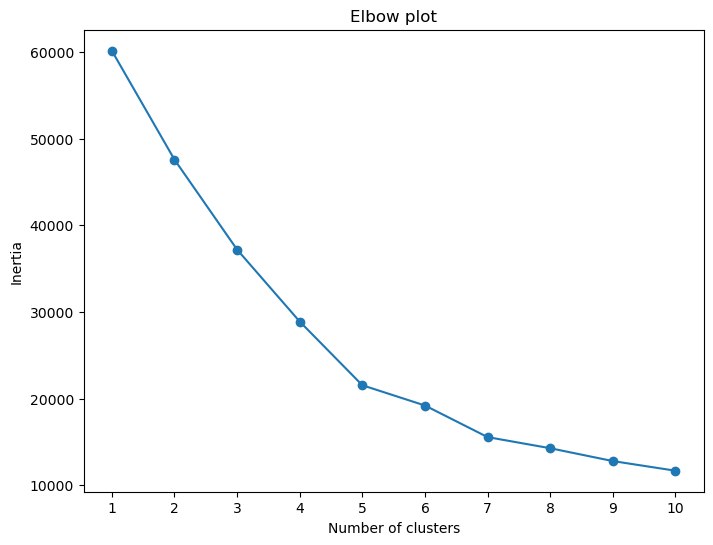

In [19]:
print_elbows(train_df1)

We can see the albow at 4-6 clusters for first df

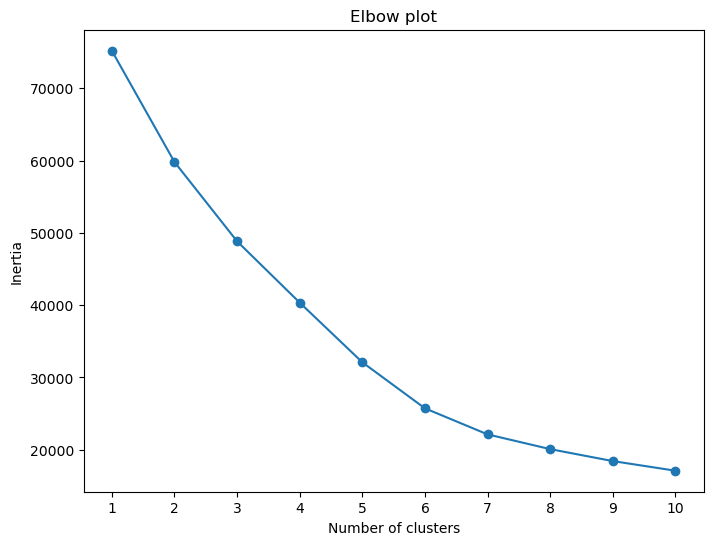

In [20]:
print_elbows(train_df2)

There is no obvious elbow for df2 but maybe around 6 or 9

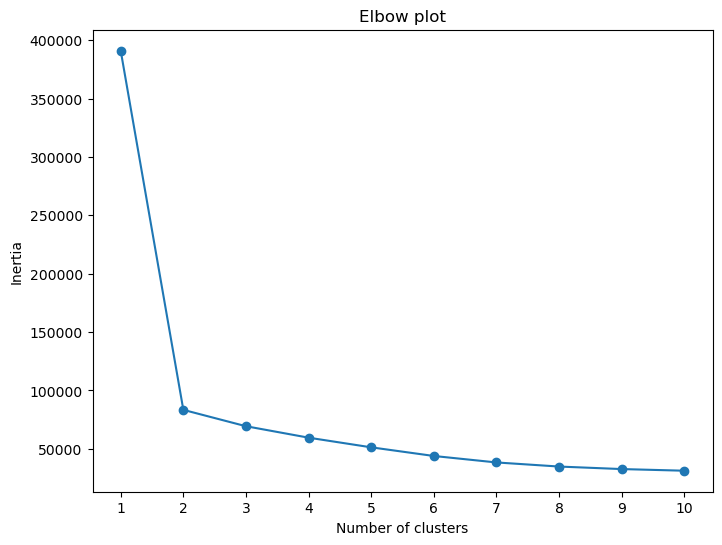

In [21]:
print_elbows(train_df3)

Here optimal number of clusters would be 2

Let's try different KMeans models with different dataframes

In [22]:
model = KMeans(n_clusters=5)
model.fit(train_df1)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.505781
1     Davies-Bouldin Score  0.751182
2  Min interclust distance  0.151374
3  Mean distance to center  2.773379
4    Inclust mean distance  3.791659


In [23]:
model=KMeans(n_clusters=8)
model.fit(train_df2)
create_report(model, train_df2)

                    Metric     Score
0         Silhouette Score  0.481062
1     Davies-Bouldin Score  0.782330
2  Min interclust distance  0.149381
3  Mean distance to center  2.089865
4    Inclust mean distance  3.102251


In [24]:
model = KMeans(n_clusters=2)
model.fit(train_df3)
create_report(model,train_df3)

                    Metric     Score
0         Silhouette Score  0.804249
1     Davies-Bouldin Score  0.282278
2  Min interclust distance  5.701534
3  Mean distance to center  1.928347
4    Inclust mean distance  2.781823


<span style="color:green;">Biggest interclust distance for KMeans</span>

In [25]:
model = KMeans(n_clusters=3)
pca = PCA(0.85)
data= pca.fit_transform(train_df3)
model.fit(data)
create_report_for_PCA(model,data)

                    Metric     Score
0         Silhouette Score  0.448543
1     Davies-Bouldin Score  0.782181
2  Min interclust distance  0.001798
3  Mean distance to center  1.043934
4    Inclust mean distance  1.473152


Best results for train_df3 and 2 clusters: silhuette score 0.8 and distance bewteen clusters is more than 5

In [26]:
param_grid={ # perform gridsearch 
    'n_clusters': range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300,400, 600]
}

model = KMeans()
reduced_df = pca.fit_transform(train_df3)
scoring = 'silhouette'
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='explained_variance')
grid_search.fit(reduced_df)

print(grid_search.best_params_)

{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10}


In [18]:
model = KMeans(n_clusters=2,n_init=10, max_iter=600)
pca = PCA(0.85)
model.fit(pca.fit_transform(train_df3))
create_report_for_PCA(model,pca.fit_transform(train_df3))

                    Metric     Score
0         Silhouette Score  0.874121
1     Davies-Bouldin Score  0.174206
2  Min interclust distance  2.114818
3  Mean distance to center  1.190049
4    Inclust mean distance  1.692866


In [21]:
model=KMeans(n_clusters=2,n_init=10,max_iter=600)
pca=PCA(0.85)
model.fit(pca.fit_transform(train_df3))
reduced_val_df = pca.fit_transform(new_val_df.drop(columns=['Phone_known','Website_known']))
predictions = model.predict(reduced_val_df)
silhouette_score(reduced_val_df,predictions)

0.8925219520599446

<span style="color:green;">Best silhuette for KMeans for train and for valid, but we loose information</span>

**Observations**
1. We have the best silhuette score for KMeans with hyperparameters and PCA
2. The biggest interclust distance is for KMeans 2 clusters and train_df3
2. KMeans with hyperparameters and PCA also has best results in minimal distance between clsuters >2

**Testing the best model on validation_set:**

In [28]:
#model 1 for validation set - KMeans with 2 clusters without PCA  that had silhuette 0.8 and interclust_dist >5
model = KMeans(n_clusters=2)
model.fit(train_df3) #trenujemy na train
predicted_clusters = model.predict(new_val_df.drop(columns=['Phone_known','Website_known'])) #testing on validation
silhouette_score(new_val_df,predicted_clusters)

0.7987614560868979

We have around 0.8 silhouette on validation set - thats a good result

# Model 2 - DBSCAN(Density based)

In [29]:
#grid search for DBSCAN
def dbscan_silhouette_score(X, labels): # custom silhuette to pass to gridSearch
    if len(set(labels)) <= 1:
        return -1
    else:
        return silhouette_score(X, labels)
    
param_grid = {
    'eps': np.linspace(0.1,15),
    'min_samples': np.arange(6,20,step=1)
}

dbscan= DBSCAN()
grid_search = GridSearchCV(dbscan, param_grid, scoring=make_scorer(dbscan_silhouette_score), cv=3, n_jobs=-1)

pca = PCA(0.85) # usingPCA to be quicker
reduced_df = pca.fit_transform(train_df3)
grid_search.fit(reduced_df)

GridSearchCV(cv=3, estimator=DBSCAN(), n_jobs=-1,
             param_grid={'eps': array([ 0.1       ,  0.40408163,  0.70816327,  1.0122449 ,  1.31632653,
        1.62040816,  1.9244898 ,  2.22857143,  2.53265306,  2.83673469,
        3.14081633,  3.44489796,  3.74897959,  4.05306122,  4.35714286,
        4.66122449,  4.96530612,  5.26938776,  5.57346939,  5.87755102,
        6.18163265,  6.48571429,  6.78979592,  7.09387755,  7.39795918,
        7.70204082,  8...71,  8.91836735,
        9.22244898,  9.52653061,  9.83061224, 10.13469388, 10.43877551,
       10.74285714, 11.04693878, 11.35102041, 11.65510204, 11.95918367,
       12.26326531, 12.56734694, 12.87142857, 13.1755102 , 13.47959184,
       13.78367347, 14.0877551 , 14.39183673, 14.69591837, 15.        ]),
                         'min_samples': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring=make_scorer(dbscan_silhouette_score))

In [30]:
print(grid_search.best_params_)

{'eps': 0.1, 'min_samples': 6}


In [31]:
model = DBSCAN(eps=0.1, min_samples=6)
pca = PCA(0.9)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
print(set(model.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Grid Search results are not safisfying as they focus on best score and create too many clusters, so let's experiment:

In [32]:
#function to return cluster labels from DBSCAN for given parameters
def dbscan_clusters(eps,min_s,dataframe):
    model = DBSCAN(eps=eps,min_samples=min_s)
    model.fit(dataframe)
    print(set(model.labels_))

In [34]:
dbscan_clusters(0.3,20,reduced_df)
model=DBSCAN(eps=0.3, min_samples=20)
model.fit(reduced_df)
create_report_for_PCA(model, reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1}
                    Metric     Score
0         Silhouette Score  0.024803
1     Davies-Bouldin Score  1.195054
2  Min interclust distance  0.029966
3  Mean distance to center  0.557631
4    Inclust mean distance  0.725846


While having a poor silhuette score, we have quite good distance to center and inclust distance

In [35]:
dbscan_clusters(0.25,20,reduced_df)
model=DBSCAN(eps=0.25, min_samples=20)
model.fit(reduced_df)
create_report_for_PCA(model, reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, -1}
                    Metric     Score
0         Silhouette Score  0.000578
1     Davies-Bouldin Score  1.288377
2  Min interclust distance  0.000607
3  Mean distance to center  0.417595
4    Inclust mean distance  0.545375


In [36]:
pca = PCA(0.88)
reduced_df = pca.fit_transform(train_df3)
dbscan_clusters(0.6,6,reduced_df)
model=DBSCAN(eps=0.6, min_samples=6)
model.fit(reduced_df)
create_report_for_PCA(model, reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
                    Metric     Score
0         Silhouette Score  0.137665
1     Davies-Bouldin Score  1.144827
2  Min interclust distance  0.113934
3  Mean distance to center  1.016056
4    Inclust mean distance  1.361018


Results aren't good. Let's try DBSCAN for df without PCA

In [37]:
dbscan_clusters(0.3,20,train_df1)
model=DBSCAN(eps=0.3,min_samples=20)
model.fit(train_df1)
create_report(model,train_df1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}
                    Metric     Score
0         Silhouette Score -0.092648
1     Davies-Bouldin Score  1.433913
2  Min interclust distance  0.004723
3  Mean distance to center  0.337746
4    Inclust mean distance  0.461669


Rather poor results when it comes to silhuette etc but we have a small distance to center (as we have epsilon) and inclust distance

In [38]:
dbscan_clusters(0.8,30,train_df3)
model=DBSCAN(eps=0.8,min_samples=30)
model.fit(train_df3)
create_report(model,train_df3)

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
                    Metric     Score
0         Silhouette Score  0.292474
1     Davies-Bouldin Score  1.238079
2  Min interclust distance  0.151377
3  Mean distance to center  1.388940
4    Inclust mean distance  1.877849


For DBSCAN results were worse than KMeans in terms of silhuette, but quite good when it comes to distance to center. The main disadvantage is the number of clusters it produces and how rapidly it can grow

# Model 3 - Agglomerative clustering(hierarchical)

Trying agglomerative clustering for different df and parameters

In [39]:
model = AgglomerativeClustering()
model.fit(train_df1)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.468152
1     Davies-Bouldin Score  1.116600
2  Min interclust distance  0.151394
3  Mean distance to center  1.498684
4    Inclust mean distance  2.133770


In [ ]:
model=AgglomerativeClustering()
pca = PCA(0.88)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.849963
1     Davies-Bouldin Score  0.205875
2  Min interclust distance  2.158902
3  Mean distance to center  1.406391
4    Inclust mean distance  2.015090


We have a good silhuette score, let's experiment with parameters

In [ ]:
model=AgglomerativeClustering(n_clusters=2)
pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.874054
1     Davies-Bouldin Score  0.173564
2  Min interclust distance  1.753212
3  Mean distance to center  1.186306
4    Inclust mean distance  1.687482


In [ ]:
model=AgglomerativeClustering(n_clusters=3)
pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.507387
1     Davies-Bouldin Score  1.005468
2  Min interclust distance  0.034317
3  Mean distance to center  1.266924
4    Inclust mean distance  1.770365


# Model 4 - Mean shift

In [40]:
model= MeanShift()
pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)
print(set(model.labels_))

                    Metric     Score
0         Silhouette Score  0.732151
1     Davies-Bouldin Score  0.473396
2  Min interclust distance  0.099399
3  Mean distance to center  1.307765
4    Inclust mean distance       NaN
{0, 1, 2, 3, 4, 5, 6, 7}


In [ ]:
model=MeanShift(max_iter=400)
model.fit(train_df1)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.482758
1     Davies-Bouldin Score  0.687839
2  Min interclust distance  0.124029
3  Mean distance to center  0.685406
4    Inclust mean distance       NaN


In [ ]:
model= MeanShift(max_iter=350)
pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.732151
1     Davies-Bouldin Score  0.473396
2  Min interclust distance  0.099399
3  Mean distance to center  1.307765
4    Inclust mean distance       NaN


# Best models interpretation

Let's look at the best scores for models according to different metrics

| Metric     | KMeans      | DBSCAN     | Agglomerative    | MeanShift      |
|:---------------|:--------------:|---------------:|:--------------:|:--------------:|
| silhouette     | **0.87**      | 0.29     | **0.87**     | 0.73     |
| min interclust      | **5.7**      | 0.15      | 2.15      | 0.12     |
| to center    | 1.04     | **0.33**    | 1.1    | 0.68     |
| mean inclust | 1.4         | **0.46**   | 1.6    | -   |



We can see that depending on our goal we should choose different models. For maximizing:

* silhuette : KMeans/Agglomerative
* good cluster separation : KMeans
* good representation by center: DBSCAN
* little distances between points in one cluster: DBSCAN

In [22]:
#function to assign cluster labels as a new column
def assign_cluster_labels(model, data): #model must be fit!
    labels = model.labels_
    df_with_labels = pd.DataFrame(data, columns=data.columns)
    df_with_labels['cluster_label'] = labels
    return df_with_labels

## Interpetation for KMeans

We got best results for PCA reduced data. Let's set the threshold to 0.88 and see the interpretation of our model

In [27]:
model=KMeans(n_clusters=2,max_iter=600)
pca = PCA(0.88)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)
predictions = model.predict(reduced_df) #fitting model and making predictions

k_mean_reduced_labeled = train_df3.copy(deep=True) #adding a new column with cluster-labels
k_mean_reduced_labeled['cluster_label']=predictions
k_mean_reduced_labeled

                    Metric     Score
0         Silhouette Score  0.849963
1     Davies-Bouldin Score  0.205875
2  Min interclust distance  2.158902
3  Mean distance to center  1.406391
4    Inclust mean distance  2.015090


,review_count,rating,verified,Friday_morning,Friday_afternoon,Friday_evening,Saturday_morning,Saturday_afternoon,Saturday_evening,Sunday_morning,...,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,main_category,geo_cluster,cluster_label
0,-0.116107,1.012531,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,0.568061,-0.528633,0
1,-0.117847,1.012531,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,-2.349915,-0.528633,0
2,0.120765,-0.349834,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,0.721638,0.234260,0
3,-0.085535,0.255662,0.650128,2.693347,2.693347,2.693347,2.641638,2.641638,2.641638,2.617874,...,2.640837,2.639237,2.639237,2.639237,2.640837,2.640837,2.640837,0.260905,-0.528633,1
4,-0.082304,0.861157,0.650128,2.693347,2.693347,2.693347,2.641638,2.641638,2.641638,2.617874,...,2.640837,2.639237,2.639237,2.639237,2.640837,2.640837,2.640837,0.568061,-0.528633,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15034,-0.045021,-1.863572,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,-0.814138,-0.528633,0
15035,-0.065651,-0.198460,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,-1.582027,2.522939,0
15036,-0.111385,0.104288,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,0.568061,2.522939,0
15037,-0.107408,-1.712198,0.650128,-0.371285,-0.371285,-0.371285,-0.378553,-0.378553,-0.378553,-0.381989,...,-0.378668,-0.378897,-0.378897,-0.378897,-0.378668,-0.378668,-0.378668,-2.042760,0.234260,0


Let's find out most important features for clusters 0 and 1 using Random Forest as for a classification problem

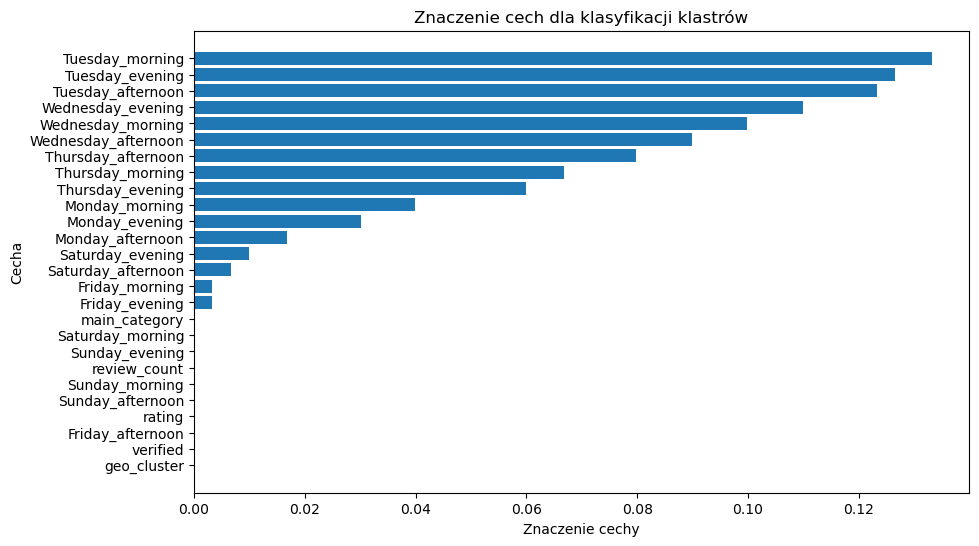

In [28]:
y0 = k_mean_reduced_labeled['cluster_label']
X0=k_mean_reduced_labeled.drop(columns=['cluster_label'])

rf = RandomForestClassifier(n_estimators=300, random_state=42) # transfering to classification problem - target = cluster
rf.fit(X0,y0)
importances = rf.feature_importances_
features = X0.columns

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Znaczenie cechy')
plt.ylabel('Cecha')
plt.title('Znaczenie cech dla klasyfikacji klastrów')
plt.gca().invert_yaxis()
plt.show()

We can see that opening hours are the most important for clusters. Let's understand it further

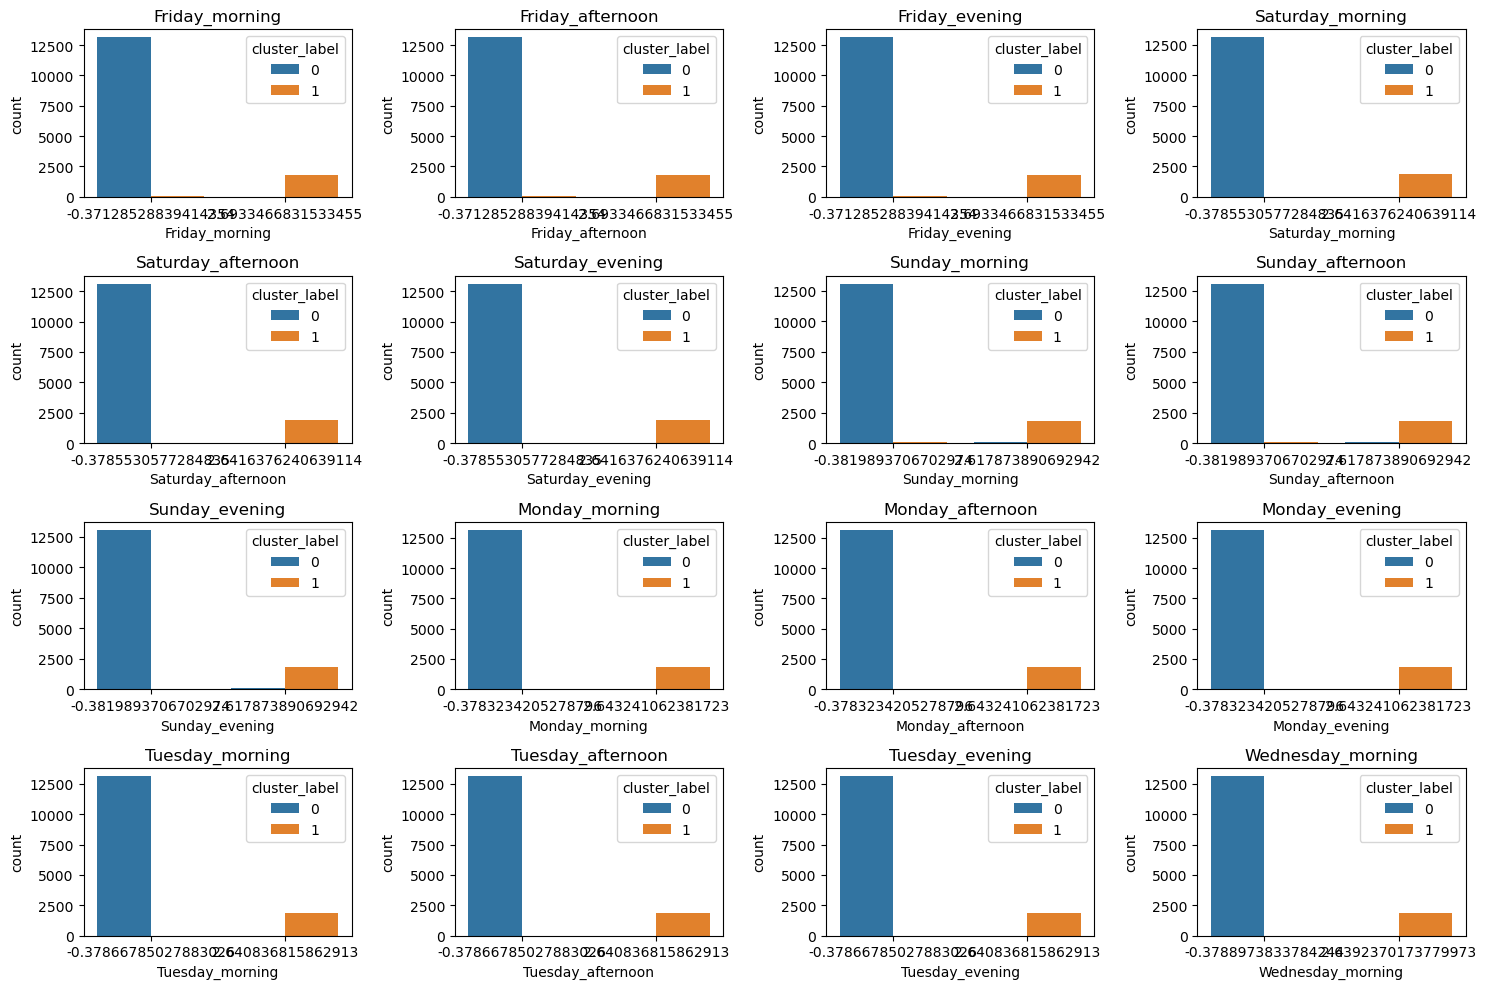

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10)) # plotting most important features
columns = ['Friday_morning',
       'Friday_afternoon', 'Friday_evening', 'Saturday_morning',
       'Saturday_afternoon', 'Saturday_evening', 'Sunday_morning',
       'Sunday_afternoon', 'Sunday_evening', 'Monday_morning',
       'Monday_afternoon', 'Monday_evening', 'Tuesday_morning',
       'Tuesday_afternoon', 'Tuesday_evening', 'Wednesday_morning',
       'Wednesday_afternoon', 'Wednesday_evening', 'Thursday_morning',
       'Thursday_afternoon', 'Thursday_evening']
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=k_mean_reduced_labeled, x=column,hue='cluster_label', ax=ax) # plotting opening hours vs cluster
    ax.set_title(column)
plt.tight_layout()
plt.show()

As we found out from EDA most of the companies are still open or still closed, to we can see that cluster 0 mostly has closed companies while cluster 1 open ones. Let's interpret particular results with shap:

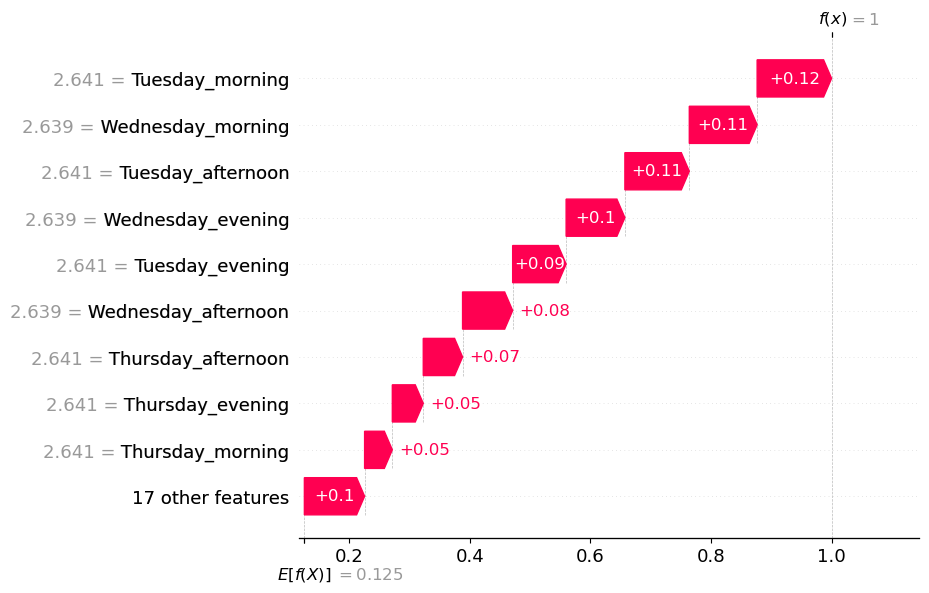

In [30]:
y0 = k_mean_reduced_labeled['cluster_label'] # shap plots for most important features
X0=k_mean_reduced_labeled.drop(columns=['cluster_label'])

model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X0,y0)
X_sample = X0.sample(n=200)
explainer = shap.Explainer(model)
shap_values = explainer(X_sample) 
shap.waterfall_plot(shap_values[:,:,1][71]) 

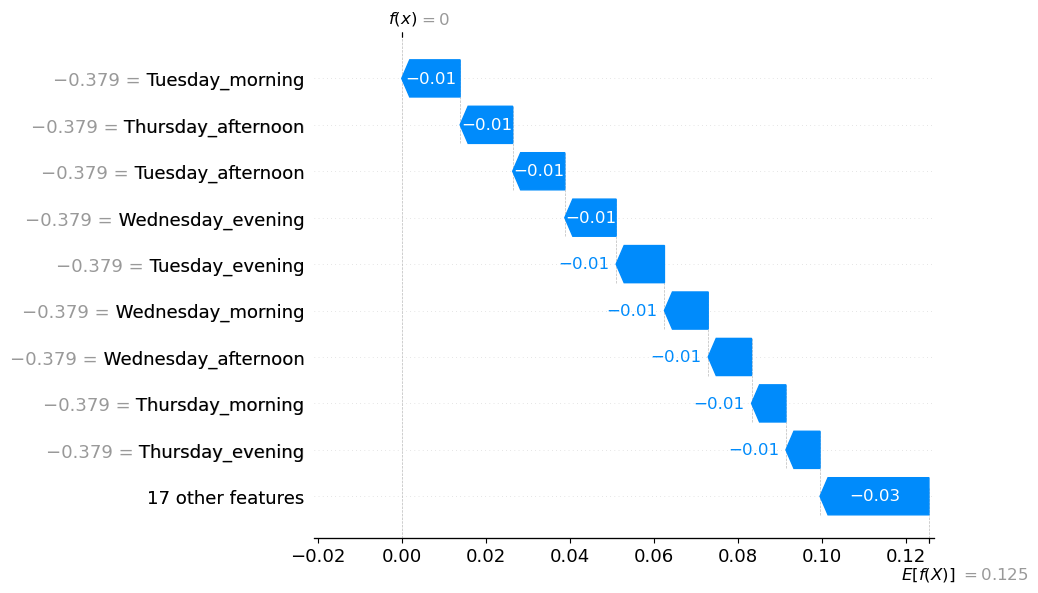

In [ ]:
shap.waterfall_plot(shap_values[:,:,1][3]) 

The fact that a given company is open in given hours shifts the prediction towards cluster 1 and when the company is closed it shifts the prediction towards cluster 0

### interpretation for val_df

In [33]:
#repeting the process above but using validation df
model = KMeans(n_clusters=2,max_iter=600)
pca = PCA(3)
pca2=PCA(3)
val_df = new_val_df.drop(columns=['Phone_known','Website_known'])
val_df_reduced= pca.fit_transform(val_df) # deleting those columns as they are not in train_df3 
train_df_reduced = pca2.fit_transform(train_df3)
model.fit(train_df_reduced) #fit on train_df
predictions = model.predict(val_df_reduced) #then predict on val_df


k_mean_labeled_reduced_val = val_df.copy(deep=True)
k_mean_labeled_reduced_val['cluster_label'] = predictions

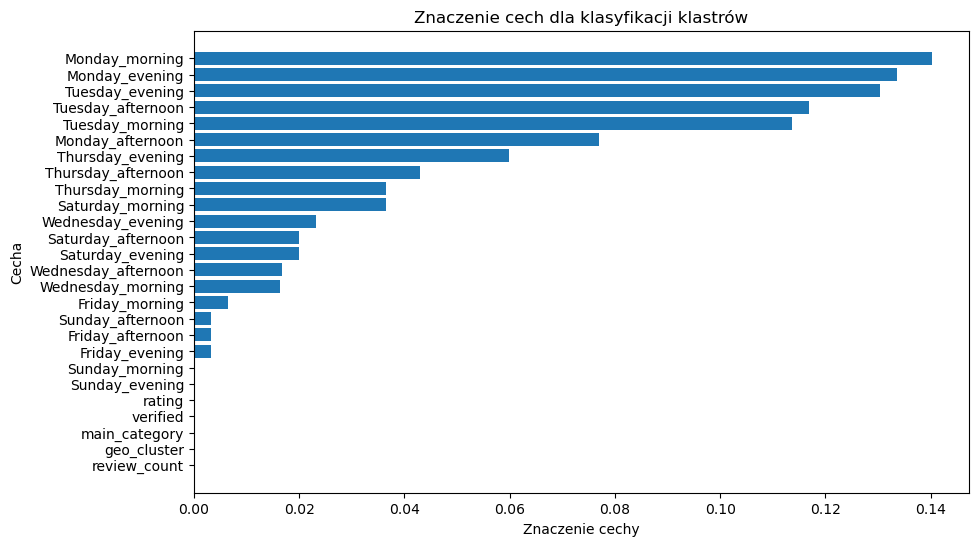

In [34]:
y0 = k_mean_labeled_reduced_val['cluster_label'] # Random Forest feature importances for validation df
X0=k_mean_labeled_reduced_val.drop(columns=['cluster_label'])

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X0,y0)
importances = rf.feature_importances_
features = X0.columns

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Znaczenie cechy')
plt.ylabel('Cecha')
plt.title('Znaczenie cech dla klasyfikacji klastrów')
plt.gca().invert_yaxis()
plt.show()

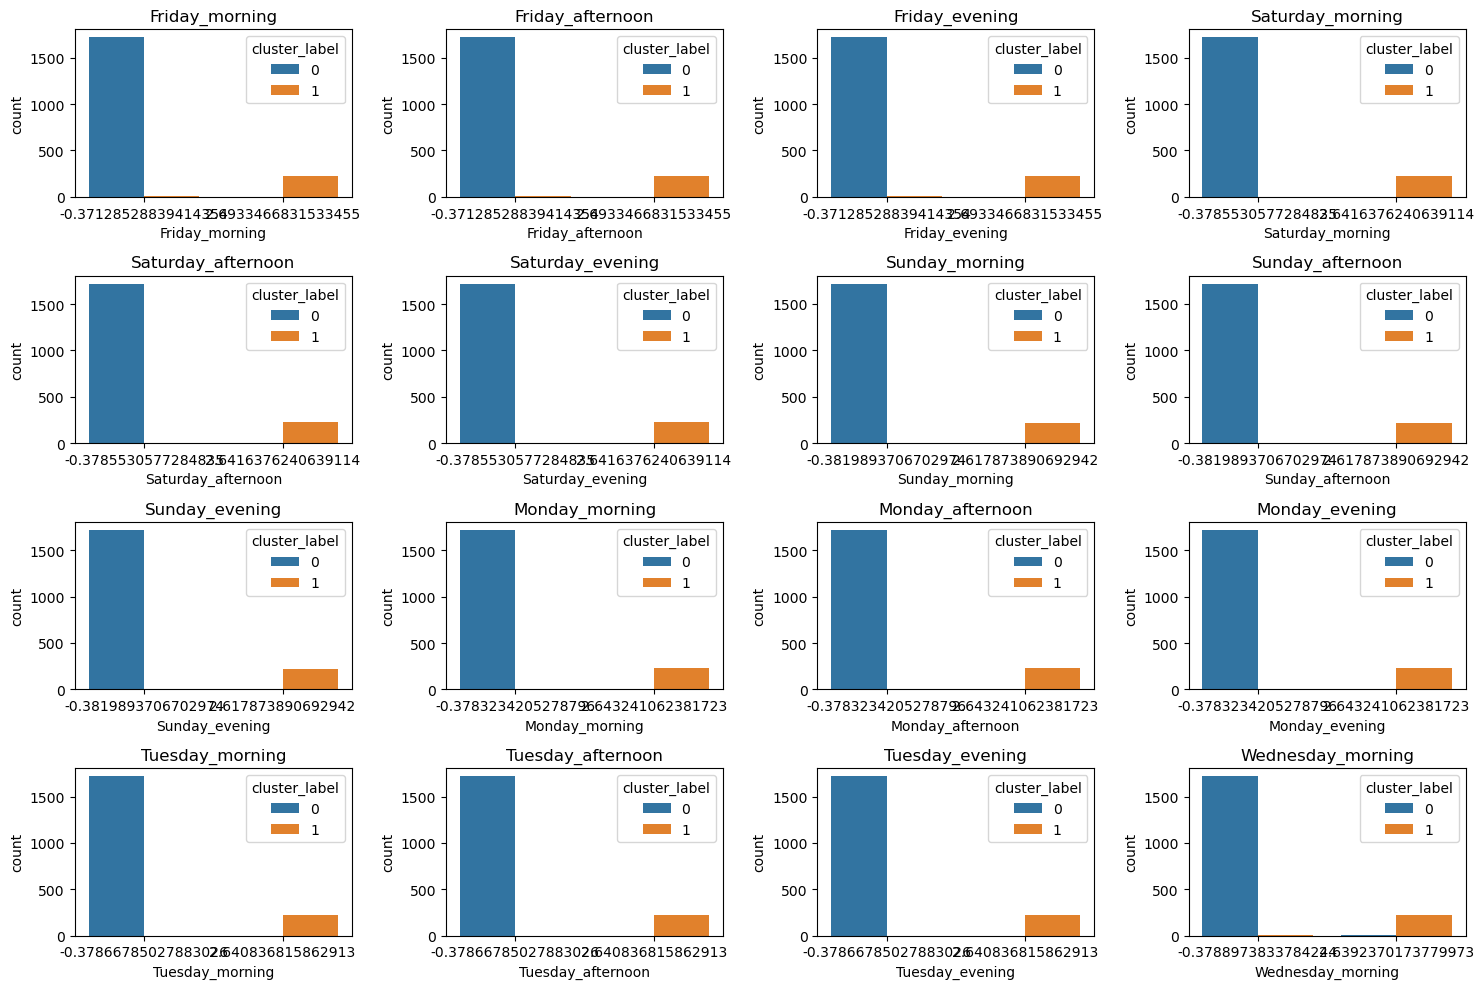

In [35]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
columns = ['Friday_morning',
       'Friday_afternoon', 'Friday_evening', 'Saturday_morning',
       'Saturday_afternoon', 'Saturday_evening', 'Sunday_morning',
       'Sunday_afternoon', 'Sunday_evening', 'Monday_morning',
       'Monday_afternoon', 'Monday_evening', 'Tuesday_morning',
       'Tuesday_afternoon', 'Tuesday_evening', 'Wednesday_morning',
       'Wednesday_afternoon', 'Wednesday_evening', 'Thursday_morning',
       'Thursday_afternoon', 'Thursday_evening']
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=k_mean_labeled_reduced_val, x=column,hue='cluster_label', ax=ax) # plotting opening hours vs cluster
    ax.set_title(column)
plt.tight_layout()
plt.show()

Results similar on validation set

## Interpretation for DBSCAN

Second best results were from DBSCAN - let's see if there is a clear interpretation when there are so many clusters

In [ ]:
model = DBSCAN(eps=0.3,min_samples=20)
df= train_df1

model.fit(df)
print(set(model.labels_))
dbscan_labeled_df = assign_cluster_labels(model,df)
dbscan_labeled_df

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}


,geo_cluster,rating,review_count,main_category,cluster_label
0,-0.53,1.01,-0.12,0.57,0
1,-0.53,1.01,-0.12,-2.35,0
2,0.23,-0.35,0.12,0.72,1
3,-0.53,0.26,-0.09,0.26,0
4,-0.53,0.86,-0.08,0.57,0
...,...,...,...,...,...
15034,-0.53,-1.86,-0.05,-0.81,-1
15035,2.52,-0.20,-0.07,-1.58,-1
15036,2.52,0.10,-0.11,0.57,12
15037,0.23,-1.71,-0.11,-2.04,-1


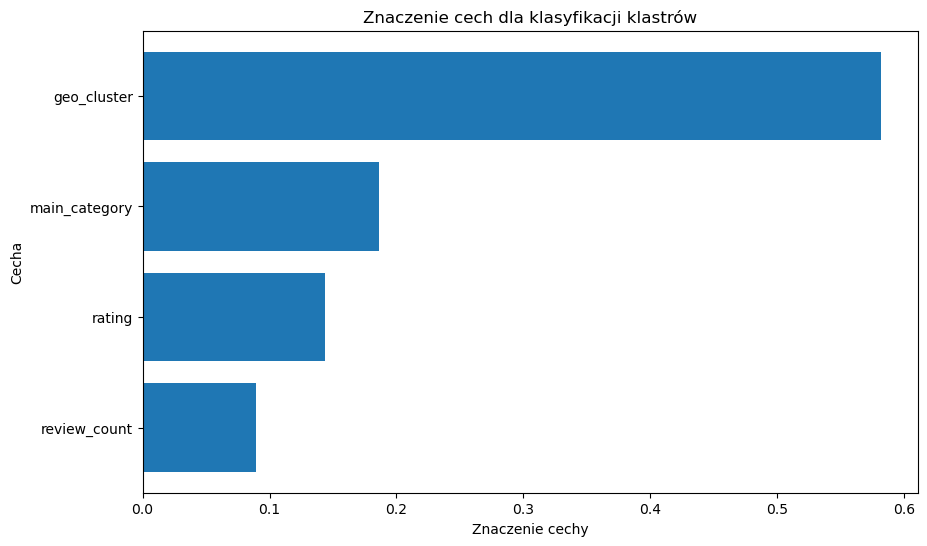

In [ ]:
# RF feature importances for DBSCAN
y0 = dbscan_labeled_df['cluster_label']
X0=dbscan_labeled_df.drop(columns=['cluster_label'])

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X0,y0)
importances = rf.feature_importances_
features = X0.columns

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Znaczenie cechy')
plt.ylabel('Cecha')
plt.title('Znaczenie cech dla klasyfikacji klastrów')
plt.gca().invert_yaxis()
plt.show()

Let's look at some statistics for this clusters

In [ ]:
most_common_values = dbscan_labeled_df.groupby('cluster_label').agg(lambda x: x.value_counts().idxmax()) 
most_common_values # most common value of each feature in given cluster

,geo_cluster,rating,review_count,main_category
cluster_label,,,,
-1,-0.53,0.41,-0.12,1.18
0,-0.53,0.10,-0.11,-0.05
1,0.23,0.10,-0.11,0.88
2,1.00,0.10,-0.11,-0.81
3,0.23,0.10,-0.11,-2.04
4,3.29,0.10,-0.11,0.88
5,-0.53,-2.01,-0.12,-2.50
6,0.23,0.10,-0.11,-0.05
7,3.29,0.10,-0.11,-0.05


It's not so easy to interpret what values are in what clusters. We can see that most common values are the same in many clusters and different features

# Business goal clustering idea

At this point we can see that KMeans model pays attention to opening hours and splits the data into 2 clusters -closed and open. However, we don't use the first geo_clustering we did previously. To make our clustering stronger we can look at each KMeans clusters based on the location.

In [36]:
set(k_mean_reduced_labeled['geo_cluster']) # question - can we get back original geo-clusters?

{-0.5286326818024044,
 0.23426021730769636,
 0.9971531164177971,
 1.7600460155278979,
 2.5229389146379986,
 3.2858318137480995}

In [40]:
#getting back numbers of geo_clusters before Standatdization
second_standardizer = standardizer.steps[0][1]
second_standardizer_val = standardizer.steps[0][1]
df = k_mean_reduced_labeled
df_val = k_mean_labeled_reduced_val
# inverse transform for this df from second standardizer to better interpret the results
original_geo_cluster = second_standardizer.inverse_transform(df)
original_geo_cluster_val = second_standardizer_val.inverse_transform(df_val)
original_geo_cluster_val

,review_count,rating,verified,Friday_morning,Friday_afternoon,Friday_evening,Saturday_morning,Saturday_afternoon,Saturday_evening,Sunday_morning,...,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,main_category,geo_cluster,cluster_label
0,-0.112580,-1.175078,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1
1,-0.137328,-2.367730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0
2,-0.131246,0.166657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0
3,-0.137748,1.061147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,5.0,0
4,-0.106707,0.613902,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,-0.063712,-0.131506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0
1945,-0.061405,-0.131506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,4.0,0
1946,-0.126841,0.017575,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0
1947,-0.086782,0.464820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,5.0,0


### Interpretation Example for geo-cluster 0

In [41]:
# lets split based on the geo-clusters (focusing on cluster0):
cluster0 = original_geo_cluster[original_geo_cluster['geo_cluster']==0]
cluster0_val = original_geo_cluster_val[original_geo_cluster_val['geo_cluster']==0]

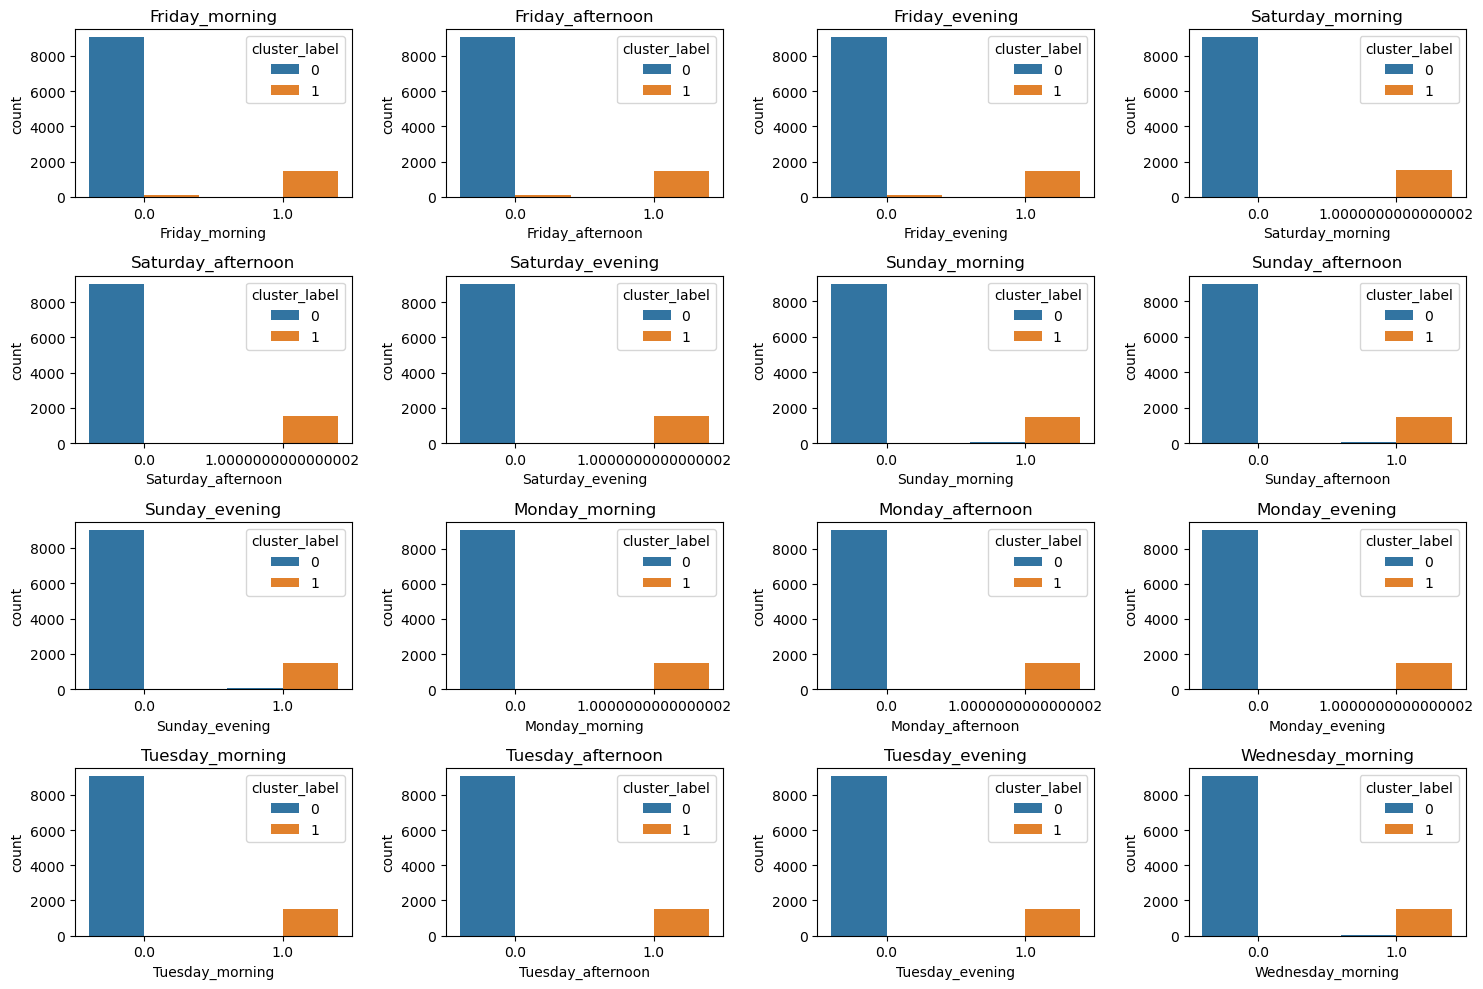

In [42]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10)) # same plots as before. lets see if results are the same
columns = ['Friday_morning',
       'Friday_afternoon', 'Friday_evening', 'Saturday_morning',
       'Saturday_afternoon', 'Saturday_evening', 'Sunday_morning',
       'Sunday_afternoon', 'Sunday_evening', 'Monday_morning',
       'Monday_afternoon', 'Monday_evening', 'Tuesday_morning',
       'Tuesday_afternoon', 'Tuesday_evening', 'Wednesday_morning',
       'Wednesday_afternoon', 'Wednesday_evening', 'Thursday_morning',
       'Thursday_afternoon', 'Thursday_evening']
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=cluster0, x=column,hue='cluster_label', ax=ax) # plotting opening hours vs cluster
    ax.set_title(column)
plt.tight_layout()
plt.show()

In [43]:
most_common_values = cluster0.groupby('cluster_label').agg(lambda x: x.value_counts().idxmax())
most_common_values # most common value of each feature in given cluster

,review_count,rating,verified,Friday_morning,Friday_afternoon,Friday_evening,Saturday_morning,Saturday_afternoon,Saturday_evening,Sunday_morning,...,Tuesday_afternoon,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,main_category,geo_cluster
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,-0.131246,0.166657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
1,-0.131246,1.061147,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,0.0


Once again we can see that KMeans grouped companies in cluster0 as closed or open

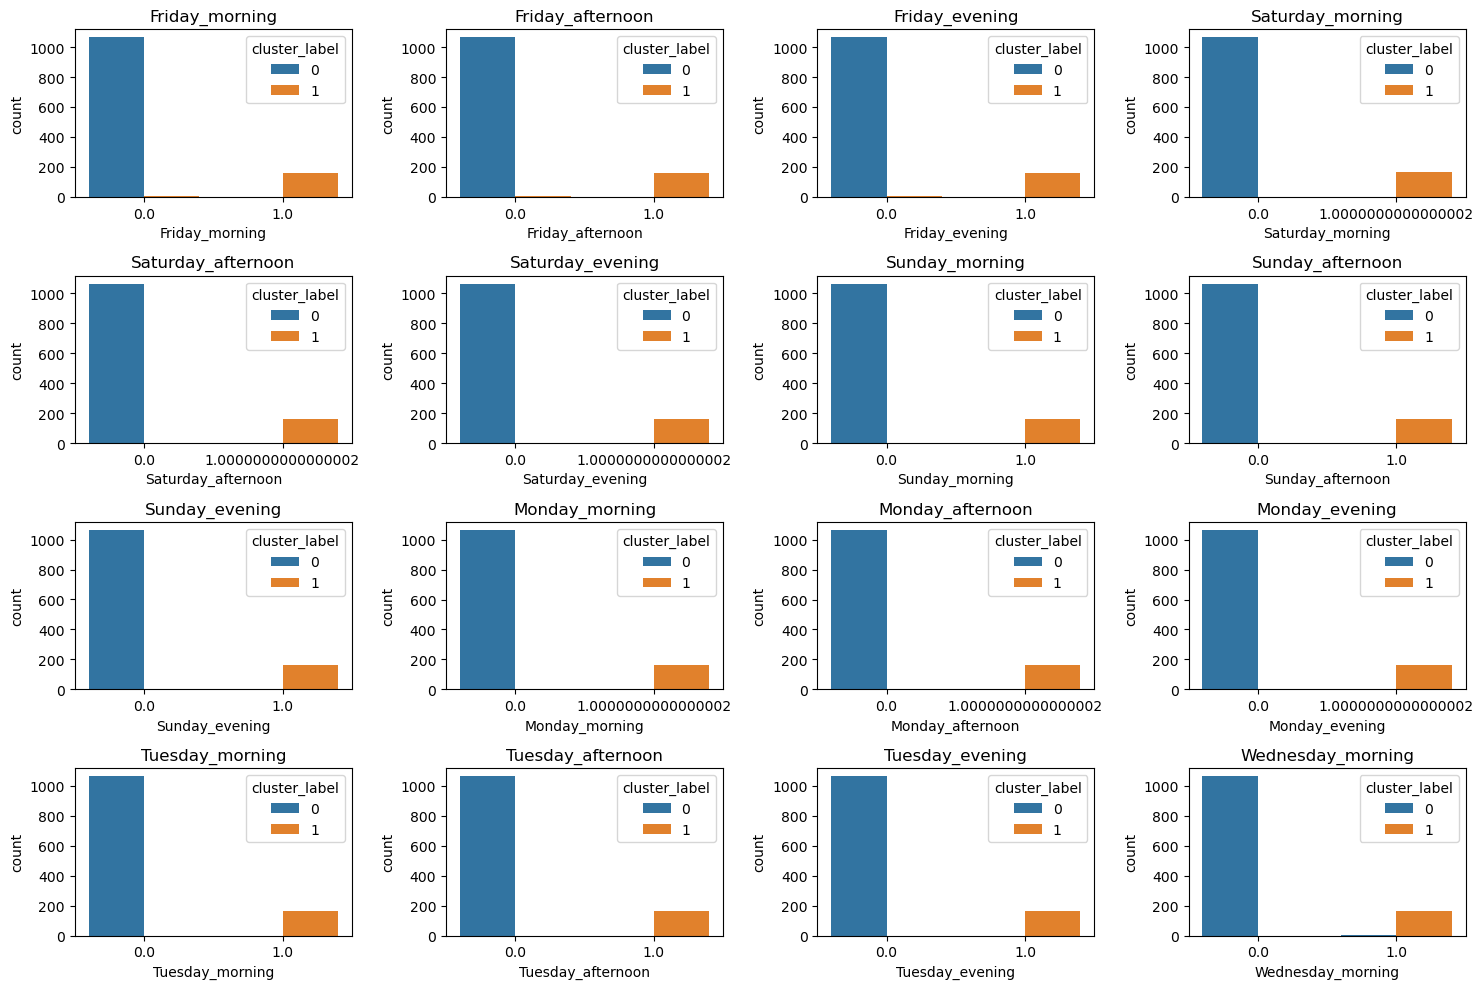

In [44]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10)) # validation set:
columns = ['Friday_morning',
       'Friday_afternoon', 'Friday_evening', 'Saturday_morning',
       'Saturday_afternoon', 'Saturday_evening', 'Sunday_morning',
       'Sunday_afternoon', 'Sunday_evening', 'Monday_morning',
       'Monday_afternoon', 'Monday_evening', 'Tuesday_morning',
       'Tuesday_afternoon', 'Tuesday_evening', 'Wednesday_morning',
       'Wednesday_afternoon', 'Wednesday_evening', 'Thursday_morning',
       'Thursday_afternoon', 'Thursday_evening']
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=cluster0_val, x=column,hue='cluster_label', ax=ax) # plotting opening hours vs cluster
    ax.set_title(column)
plt.tight_layout()
plt.show()

Also results for val_df the same

# Conclusion

The best model is KMeans with PCA 3 components. We must sacrifice someinformation but it can be also noise. 

We have 2 part clustering. In the first part we clustered companies based on their location. In the second part we clustered all companies to 2 groups - open and closed ones. Then we noticed that we can combine results from both clusters and create a business goal based not only on opening hours but also on location. We can easily interpret our results looking at plots and tables, as well as silhuette score and min interclust distance that is high